In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
c
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
train_file_path = "hull-tactical-market-prediction/train.csv"
test_file_path = "hull-tactical-market-prediction/test.csv"
train_df = pd.read_csv(train_file_path)
test_df = pd.read_csv(test_file_path)
print("Full train dataset shape is {}".format(train_df.shape))

Full train dataset shape is (8990, 98)


In [4]:
TARGET = "market_forward_excess_returns"
FEATURES = [col for col in train_df.columns if col not in [TARGET]]
X = train_df[FEATURES].copy()
X['forward_returns_lag'] = X['forward_returns'].shift(1)
X['risk_free_rate_lag'] = X['risk_free_rate'].shift(1)
X.drop('forward_returns', axis = 1, inplace = True)
X.drop('risk_free_rate', axis =1, inplace = True)
y = train_df[TARGET]
#X.fillna(0, inplace=True)

N_TEST_ROWS = 63
X_test = X.iloc[-N_TEST_ROWS:]
y_test = y.iloc[-N_TEST_ROWS:]
X = X.iloc[:-N_TEST_ROWS]
y = y.iloc[:-N_TEST_ROWS]

print("Full train dataset shape is {}".format(X.shape))
print(X.columns)
print(X.isna().any().sum())
print(y.isna().any().sum())

Full train dataset shape is (8927, 97)
Index(['date_id', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'E1',
       'E10', 'E11', 'E12', 'E13', 'E14', 'E15', 'E16', 'E17', 'E18', 'E19',
       'E2', 'E20', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'I1', 'I2', 'I3',
       'I4', 'I5', 'I6', 'I7', 'I8', 'I9', 'M1', 'M10', 'M11', 'M12', 'M13',
       'M14', 'M15', 'M16', 'M17', 'M18', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7',
       'M8', 'M9', 'P1', 'P10', 'P11', 'P12', 'P13', 'P2', 'P3', 'P4', 'P5',
       'P6', 'P7', 'P8', 'P9', 'S1', 'S10', 'S11', 'S12', 'S2', 'S3', 'S4',
       'S5', 'S6', 'S7', 'S8', 'S9', 'V1', 'V10', 'V11', 'V12', 'V13', 'V2',
       'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'forward_returns_lag',
       'risk_free_rate_lag'],
      dtype='object')
87
0


In [5]:
def categorize_features(df):
    """Categorize features based on their prefixes"""
    
    print("\n🏷️ FEATURE CATEGORIZATION")
    print("="*50)
    
    feature_categories = {}
    
    # Define feature categories based on prefixes
    categories = {
        'Market_Dynamics': 'M',
        'Macro_Economic': 'E',
        'Interest_Rate': 'I',
        'Price_Valuation': 'P',
        'Volatility': 'V',
        'Sentiment': 'S',
        'Momentum': 'MOM',
        'Dummy_Binary': 'D'
    }
    
    # Categorize features
    for category, prefix in categories.items():
        if prefix == 'MOM':
            feature_categories[category] = [col for col in df.columns if col.startswith(prefix)]
        else:
            feature_categories[category] = [col for col in df.columns if col.startswith(prefix) and not col.startswith('MOM')]
    
    # Special columns
    special_cols = ['date_id', 'forward_returns', 'risk_free_rate', 'market_forward_excess_returns']
    feature_categories['Special'] = [col for col in special_cols if col in df.columns]
    
    # Display categorization
    total_features = 0
    for category, features in feature_categories.items():
        print(f"📊 {category}: {len(features)} features")
        total_features += len(features)
    
    print(f"\n📈 Total categorized features: {total_features}")
    print(f"📈 Total columns in dataset: {df.shape[1]}")
    
    return feature_categories

feature_categories = categorize_features(train_df)


🏷️ FEATURE CATEGORIZATION
📊 Market_Dynamics: 18 features
📊 Macro_Economic: 20 features
📊 Interest_Rate: 9 features
📊 Price_Valuation: 13 features
📊 Volatility: 13 features
📊 Sentiment: 12 features
📊 Momentum: 0 features
📊 Dummy_Binary: 9 features
📊 Special: 4 features

📈 Total categorized features: 98
📈 Total columns in dataset: 98


## hmm_cluster

In [6]:
class create_hmm_regime(BaseEstimator, TransformerMixin):
    
    def __init__(self, feature_categories, window=50, n_regimes=None, 
                 max_regimes=16, metric_for_k='bic', predict_type='proba',
                 n_inits=3, # <-- NEW: Number of times to re-fit
                 random_state=42):
        """
        __init__ modified for HMM.
        
        n_clusters -> n_regimes: The number of hidden states (regimes).
        max_regimes: The max number to search if n_regimes is None.
        metric_for_k: 'bic' or 'aic'. HMMs use likelihood-based metrics, not Silhouette.
        predict_type: 'proba' (recom'd) or 'labels'.
                      'proba' = probability of being in each regime (e.g., [0.1, 0.9, 0.0])
                      'labels' = the most likely regime (e.g., 1)
        """
        
        self.feature_categories = feature_categories
        self.window = window
        self.n_regimes = n_regimes
        self.max_regimes = max_regimes
        self.metric_for_k = metric_for_k
        self.predict_type = predict_type
        self.n_inits = n_inits # <-- NEW
        self.random_state = random_state

    def _detrend_and_standardize(self, df):
        # This function is unchanged.
        df_transformed = df.copy()
        window = self.window
        for category, features in self.feature_categories.items():
            features = [f for f in features if f in df_transformed.columns]
            if category in ['Price_Valuation', 'Macro_Economic']:
                for feature in features:
                    df_transformed[feature] = df_transformed[feature].diff().fillna(0)
            elif category not in ['Dummy_Binary', 'Special']:
                for feature in features:
                    rolling_mean = df_transformed[feature].rolling(window=window).mean()
                    rolling_std = df_transformed[feature].rolling(window=window).std()
                    rolling_std.replace(0.0, 1.0, inplace=True) 
                    df_transformed[feature] = (df_transformed[feature] - rolling_mean) / rolling_std
                    df_transformed[feature] = df_transformed[feature].fillna(0)
        return df_transformed
    # ----------------------------------------------------------------------

    def fit(self, X, y=None):
        # 1. & 2. & 3. Preprocessing (unchanged)
        feature_cols = []
        for category, features in self.feature_categories.items():
            if category != 'Special':
                feature_cols.extend(features)
        
        self.feature_cols = [f for f in feature_cols if f in X.columns]
        X_cluster = X[self.feature_cols]
        self.imputer = SimpleImputer(strategy='median').set_output(transform="pandas")
        X_imputed = self.imputer.fit_transform(X_cluster)
        X_processed = self._detrend_and_standardize(X_imputed)
        X_fit_data = X_processed.values[self.window:]

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            
            if self.n_regimes is None:
                # 4. Find optimal 'k' (NOW MORE ROBUST)
                scores = []
                k_range = range(2, self.max_regimes + 1)
                
                for k in k_range:
                    best_k_score = np.inf
                    # Try n_inits times for this 'k'
                    for i in range(self.n_inits):
                        try:
                            hmm = GaussianHMM(n_components=k, 
                                              random_state=self.random_state + i, # Use different seed
                                              covariance_type="diag", n_iter=100)
                            hmm.fit(X_fit_data)
                            
                            score = hmm.bic(X_fit_data) if self.metric_for_k == 'bic' else hmm.aic(X_fit_data)
                            
                            if score < best_k_score:
                                best_k_score = score
                        except ValueError:
                            pass # Fit failed, ignore this init
                    
                    scores.append(best_k_score)
                
                self.optimal_regimes = k_range[np.argmin(scores)]
                print(f"\nOptimal number of regimes ({self.metric_for_k}): {self.optimal_regimes}")
            else:
                self.optimal_regimes = self.n_regimes
                print(f"\nUsing specified number of regimes: {self.optimal_regimes}")

            # 5. Train final HMM (NOW MORE ROBUST)
            best_final_score = -np.inf
            best_hmm = None
            
            # Try n_inits times for the final model
            for i in range(self.n_inits):
                try:
                    hmm = GaussianHMM(n_components=self.optimal_regimes, 
                                      random_state=self.random_state + i, # Use different seed
                                      covariance_type="diag", n_iter=100)
                    hmm.fit(X_fit_data)
                    
                    # We use the raw log-likelihood score to find the best fit
                    score = hmm.score(X_fit_data) 
                    
                    if score > best_final_score:
                        best_final_score = score
                        best_hmm = hmm
                except ValueError:
                    pass # Fit failed
            
            self.hmm = best_hmm # Save the best model found
            
        if self.hmm is None:
             raise RuntimeError("HMM fitting failed for all initializations.")
                
        return self
        
    def transform(self, X):
        # This function is unchanged
        X_transformed = X.copy()
        X_cluster = X[self.feature_cols]
        X_imputed = self.imputer.transform(X_cluster)
        X_processed = self._detrend_and_standardize(X_imputed)
        X_processed_values = X_processed.values

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            if self.predict_type == 'proba':
                probas = self.hmm.predict_proba(X_processed_values)
                proba_cols = [f"regime_{i}_prob" for i in range(self.optimal_regimes)]
                X_transformed[proba_cols] = probas
            else:
                labels = self.hmm.predict(X_processed_values)
                X_transformed["regime"] = labels
            
        return X_transformed

In [7]:
hmm_cluster = create_hmm_regime(
    feature_categories=feature_categories,
    predict_type='labels',
    max_regimes=16
)
    

## time series plot

训练周期: index 0 to 4462 | 测试周期: index 4463 to 5354


d:\Softwares\anaconda\envs\dsml\Lib\site-packages\sklearn\impute\_base.py:637: UserWarning: Skipping features without any observed values: ['M1' 'M13' 'M14' 'M6' 'E7' 'V10' 'V9' 'S3']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Model is not converging.  Current: 266397.31174229935 is not greater than 266404.0591398095. Delta is -6.747397510160226
Model is not converging.  Current: 266397.31174229935 is not greater than 266404.0591398095. Delta is -6.747397510160226
Model is not converging.  Current: 129056.04980239342 is not greater than 129057.66771093875. Delta is -1.6179085453331936
Model is not converging.  Current: 129056.04980239342 is not greater than 129057.66771093875. Delta is -1.6179085453331936
Model is not converging.  Current: 310606.05354789295 is not greater than 310606.46368340985. Delta is -0.4101355168968439
Model is not converging.  Current: 310606.05354789295 is not greater than 310606.46368340985. Delta is -0.4


Optimal number of regimes (bic): 16


Model is not converging.  Current: 601408.8071340588 is not greater than 601409.5317790637. Delta is -0.724645004956983
Model is not converging.  Current: 414115.1973714704 is not greater than 414126.6480161978. Delta is -11.450644727388863
Model is not converging.  Current: 414115.1973714704 is not greater than 414126.6480161978. Delta is -11.450644727388863
d:\Softwares\anaconda\envs\dsml\Lib\site-packages\sklearn\impute\_base.py:637: UserWarning: Skipping features without any observed values: ['M1' 'M13' 'M14' 'M6' 'E7' 'V10' 'V9' 'S3']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
d:\Softwares\anaconda\envs\dsml\Lib\site-packages\sklearn\impute\_base.py:637: UserWarning: Skipping features without any observed values: ['M1' 'M13' 'M14' 'M6' 'E7' 'V10' 'V9' 'S3']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


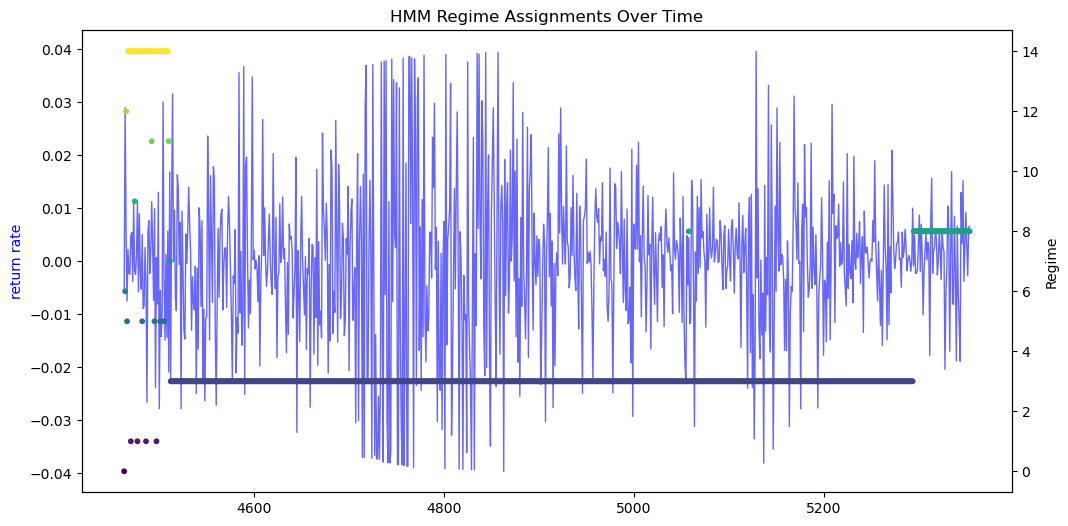

训练周期: index 892 to 5354 | 测试周期: index 5355 to 6246


d:\Softwares\anaconda\envs\dsml\Lib\site-packages\sklearn\impute\_base.py:637: UserWarning: Skipping features without any observed values: ['M1' 'M13' 'M14' 'E7' 'V10' 'S3']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Model is not converging.  Current: 11250.965192178406 is not greater than 11251.576610099884. Delta is -0.611417921478278
Model is not converging.  Current: 11250.965192178406 is not greater than 11251.576610099884. Delta is -0.611417921478278
Model is not converging.  Current: -11398.053191881685 is not greater than -11396.530945090855. Delta is -1.5222467908297403
Model is not converging.  Current: -11398.053191881685 is not greater than -11396.530945090855. Delta is -1.5222467908297403
Model is not converging.  Current: -11396.144841197176 is not greater than -11394.86274615776. Delta is -1.2820950394161628
Model is not converging.  Current: -11396.144841197176 is not greater than -11394.86274615776. Delta is -1.282


Optimal number of regimes (bic): 15


Model is not converging.  Current: 235981.2335474028 is not greater than 235985.86261955966. Delta is -4.62907215685118
Model is not converging.  Current: 301698.9132831634 is not greater than 301700.1779947997. Delta is -1.2647116362932138
Model is not converging.  Current: 301698.9132831634 is not greater than 301700.1779947997. Delta is -1.2647116362932138
d:\Softwares\anaconda\envs\dsml\Lib\site-packages\sklearn\impute\_base.py:637: UserWarning: Skipping features without any observed values: ['M1' 'M13' 'M14' 'E7' 'V10' 'S3']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
d:\Softwares\anaconda\envs\dsml\Lib\site-packages\sklearn\impute\_base.py:637: UserWarning: Skipping features without any observed values: ['M1' 'M13' 'M14' 'E7' 'V10' 'S3']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


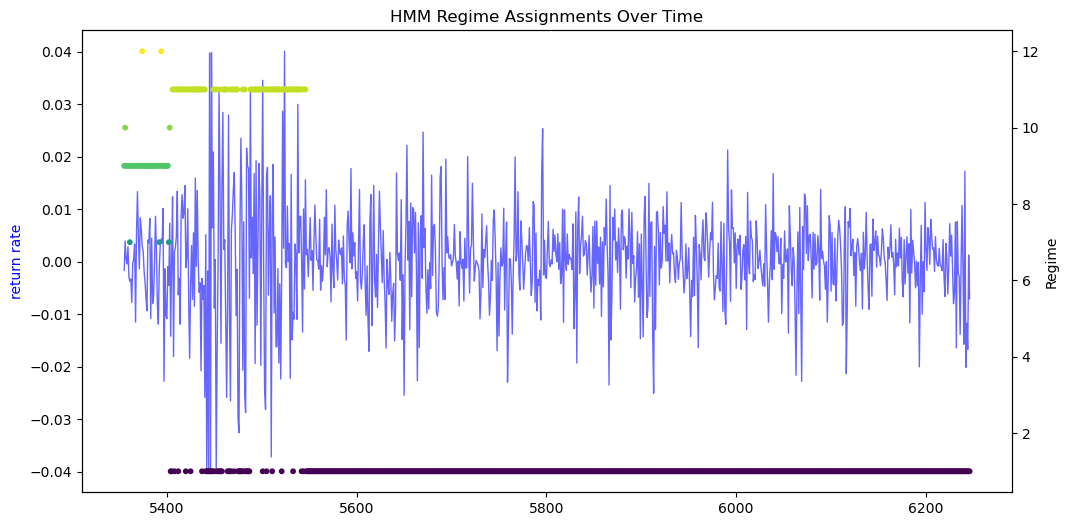

d:\Softwares\anaconda\envs\dsml\Lib\site-packages\sklearn\impute\_base.py:637: UserWarning: Skipping features without any observed values: ['E7']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


训练周期: index 1784 to 6246 | 测试周期: index 6247 to 7138


Model is not converging.  Current: -43615.14870334406 is not greater than -43608.00681607503. Delta is -7.141887269026483
Model is not converging.  Current: -62229.51517726327 is not greater than -62223.43505145082. Delta is -6.080125812448387
Model is not converging.  Current: -62229.51517726327 is not greater than -62223.43505145082. Delta is -6.080125812448387
Model is not converging.  Current: -59439.37063434459 is not greater than -59430.954436637396. Delta is -8.416197707192623
Model is not converging.  Current: -59439.37063434459 is not greater than -59430.954436637396. Delta is -8.416197707192623
Model is not converging.  Current: 79837.74501243581 is not greater than 79845.12737041131. Delta is -7.382357975497143
Model is not converging.  Current: 79837.74501243581 is not greater than 79845.12737041131. Delta is -7.382357975497143
Model is not converging.  Current: 80131.16412765336 is not greater than 80140.60082693493. Delta is -9.436699281563051
Model is not converging.  Cu


Optimal number of regimes (bic): 16


Model is not converging.  Current: 257705.66265929915 is not greater than 257705.9336435257. Delta is -0.27098422654671595
Model is not converging.  Current: 252825.5265110972 is not greater than 252825.68746411474. Delta is -0.1609530175337568
Model is not converging.  Current: 252825.5265110972 is not greater than 252825.68746411474. Delta is -0.1609530175337568
Model is not converging.  Current: 261722.62698991766 is not greater than 261722.68397457834. Delta is -0.05698466068133712
Model is not converging.  Current: 261722.62698991766 is not greater than 261722.68397457834. Delta is -0.05698466068133712
d:\Softwares\anaconda\envs\dsml\Lib\site-packages\sklearn\impute\_base.py:637: UserWarning: Skipping features without any observed values: ['E7']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
d:\Softwares\anaconda\envs\dsml\Lib\site-packages\sklearn\impute\_base.py:637: UserWarning: Skipping features without any observed values: ['

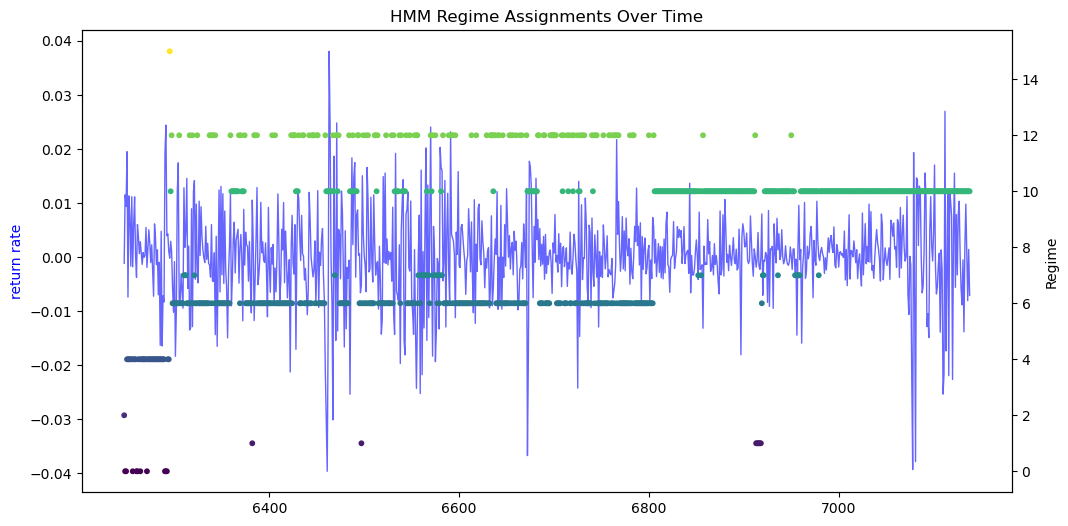

训练周期: index 2676 to 7138 | 测试周期: index 7139 to 8030


Model is not converging.  Current: -62047.79692590736 is not greater than -62047.695061274266. Delta is -0.10186463309219107
Model is not converging.  Current: -74178.98817379963 is not greater than -74165.91965847289. Delta is -13.068515326740453
Model is not converging.  Current: -74178.98817379963 is not greater than -74165.91965847289. Delta is -13.068515326740453
Model is not converging.  Current: -62047.46514604114 is not greater than -62047.336587753125. Delta is -0.1285582880154834
Model is not converging.  Current: -62047.46514604114 is not greater than -62047.336587753125. Delta is -0.1285582880154834
Model is not converging.  Current: 30939.96524333328 is not greater than 30974.32691600923. Delta is -34.3616726759501
Model is not converging.  Current: 30939.96524333328 is not greater than 30974.32691600923. Delta is -34.3616726759501
Model is not converging.  Current: 29914.13208054299 is not greater than 29921.69562078336. Delta is -7.563540240371367
Model is not converging


Optimal number of regimes (bic): 13


Model is not converging.  Current: 150969.29778919835 is not greater than 150969.38639926809. Delta is -0.08861006973893382
Model is not converging.  Current: 171589.4449945594 is not greater than 171603.6213169597. Delta is -14.176322400307981
Model is not converging.  Current: 171589.4449945594 is not greater than 171603.6213169597. Delta is -14.176322400307981
Model is not converging.  Current: 164362.70090682426 is not greater than 164364.5464059754. Delta is -1.8454991511243861
Model is not converging.  Current: 164362.70090682426 is not greater than 164364.5464059754. Delta is -1.8454991511243861


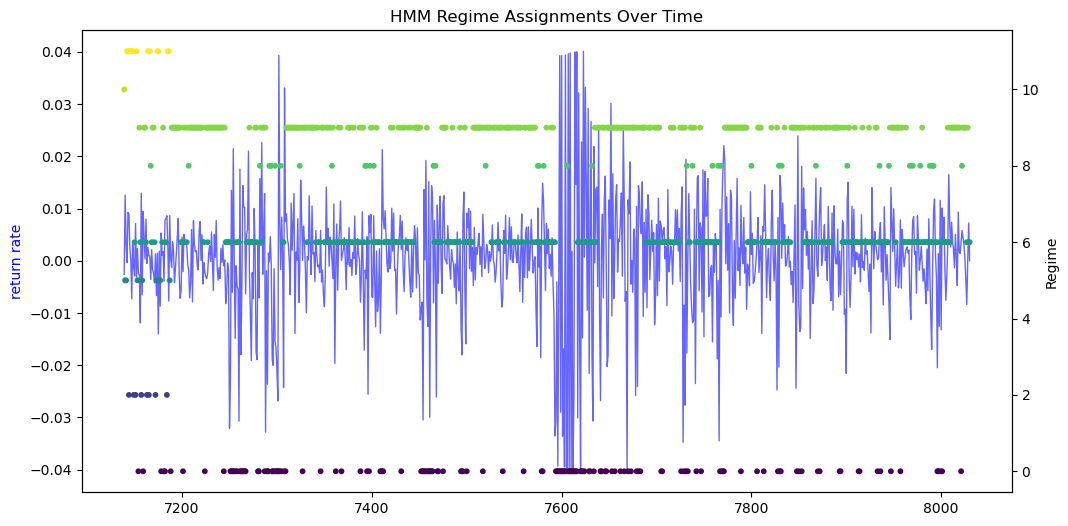

训练周期: index 3568 to 8030 | 测试周期: index 8031 to 8922


Model is not converging.  Current: -92927.10150419311 is not greater than -92896.78736302143. Delta is -30.314141171678784
Model is not converging.  Current: -59224.25397751428 is not greater than -59223.885568870515. Delta is -0.3684086437642691
Model is not converging.  Current: -59224.25397751428 is not greater than -59223.885568870515. Delta is -0.3684086437642691
Model is not converging.  Current: -70293.36312356159 is not greater than -70289.93668237365. Delta is -3.4264411879412364
Model is not converging.  Current: -70293.36312356159 is not greater than -70289.93668237365. Delta is -3.4264411879412364
Model is not converging.  Current: -68829.75032834399 is not greater than -68819.72418549439. Delta is -10.026142849601456
Model is not converging.  Current: -68829.75032834399 is not greater than -68819.72418549439. Delta is -10.026142849601456
Model is not converging.  Current: -27922.863461146117 is not greater than -27916.904821911023. Delta is -5.9586392350938695
Model is not


Optimal number of regimes (bic): 14


Model is not converging.  Current: 90034.29652447248 is not greater than 90034.8213422085. Delta is -0.5248177360190311
Model is not converging.  Current: 61522.99886206369 is not greater than 61523.62584710906. Delta is -0.6269850453754771
Model is not converging.  Current: 61522.99886206369 is not greater than 61523.62584710906. Delta is -0.6269850453754771
Model is not converging.  Current: 62986.965830217945 is not greater than 62991.52306406211. Delta is -4.55723384416342
Model is not converging.  Current: 62986.965830217945 is not greater than 62991.52306406211. Delta is -4.55723384416342


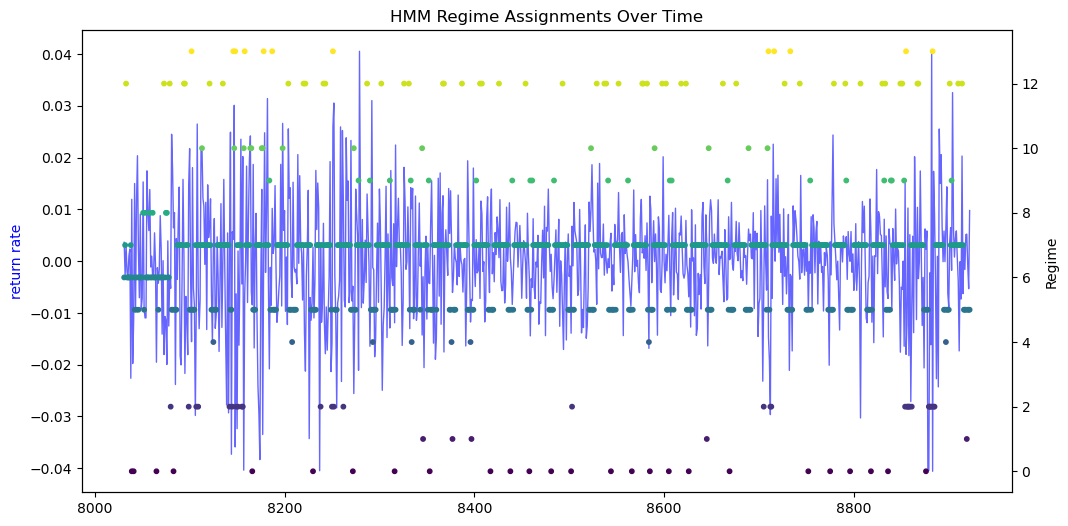

In [8]:
n_samples = len(X)
initial_train_size = int(n_samples * 0.5)
test_size = int(n_samples * 0.1)
train_start_index = 0
train_end_index = initial_train_size
test_end_index = train_end_index + test_size

while test_end_index <= n_samples:
      print(f"训练周期: index {train_start_index} to {train_end_index-1} | "
            f"测试周期: index {train_end_index} to {test_end_index-1}")

      X_train, y_train = X.iloc[train_start_index:train_end_index], y.iloc[train_start_index:train_end_index]
      X_val, y_val = X.iloc[train_end_index:test_end_index], y.iloc[train_end_index:test_end_index]


      hmm_cluster.fit(X_train)
      X_transformed = hmm_cluster.transform(X_val)

      #print(X_transformed.columns)
      fig, ax1 = plt.subplots(figsize=(12, 6))

      ax1.plot(y_val.index, y_val, linewidth=1, color='blue', label='Return Rate', alpha=0.6)
      ax1.set_ylabel('return rate', color='blue')
      
      ax2 = ax1.twinx()
      ax2.scatter(X_transformed['date_id'], X_transformed['regime'], c=X_transformed['regime'], cmap='viridis', s=10)
      ax2.set_ylabel('Regime', color='black')
      
      
      plt.title('HMM Regime Assignments Over Time')
      plt.xlabel('Date ID')
      plt.ylabel('Regime')
      plt.show()

      # --- (更新索引) ---
      train_start_index += test_size
      train_end_index += test_size
      test_end_index += test_size

# Final Test Set Evaluation (Last 180 Days)

Evaluate the HMM regime model on a held-out test set consisting of the last 180 days of data.

In [9]:
# Helper function for Sharpe ratio calculation
def ad_sharpe_ratio_scorer(y_pred, y_true):
    """
    Calculate Sharpe ratio (non-annualized) matching base-v1 methodology.
    
    Parameters:
    y_pred: Model predictions
    y_true: Actual returns
    
    Returns:
    float: Sharpe ratio
    """
    y_pred = y_pred.astype(float)
    y_true = y_true.astype(float)
    
    # Calculate strategy returns
    positions = np.where(y_pred > 0, y_pred, 0)
    strategy_returns = positions * y_true
    
    # Calculate Sharpe ratio
    mean_return = np.mean(strategy_returns)
    std_return = np.std(strategy_returns)
    
    epsilon = 1e-8
    sharpe_ratio = mean_return / (std_return + epsilon)
    
    return sharpe_ratio

print("Helper functions loaded.")

Helper functions loaded.


In [13]:
# Note: This notebook uses a simpler approach - just HMM regime detection
# For a complete model comparison, you would need to integrate this with a predictive model
# Here we'll create a simple baseline by training on the training set

from sklearn.metrics import r2_score
from catboost import CatBoostRegressor

print("\n" + "="*60)
print("FINAL TEST SET EVALUATION - LAST 180 DAYS")
print("="*60)



TEST_DAYS = 180
X = X[-TEST_DAYS*10:]
y = y[-TEST_DAYS*10:]
n_total = len(X)

# Split data into training and test sets
X_train_full = X.iloc[:-TEST_DAYS]
y_train_full = y.iloc[:-TEST_DAYS]
X_test_holdout = X.iloc[-TEST_DAYS:]
y_test_holdout = y.iloc[-TEST_DAYS:]

print(f"\nTotal samples: {n_total}")
print(f"Training set: {len(X_train_full)} samples")
print(f"Test set (last {TEST_DAYS} days): {len(X_test_holdout)} samples")

# Fit HMM on training data and transform both sets
print("\nFitting HMM regime model on training data...")
hmm_cluster.fit(X_train_full)

print("Transforming training and test data with HMM regimes...")
X_train_with_regimes = hmm_cluster.transform(X_train_full)
X_test_with_regimes = hmm_cluster.transform(X_test_holdout)

# Prepare features for modeling
# Drop special columns and use regime information
features_to_drop = ['date_id', 'forward_returns_lag', 'risk_free_rate_lag']
feature_cols = [col for col in X_train_with_regimes.columns 
                if col not in features_to_drop and not col.startswith('regime_')]

X_train_model = X_train_with_regimes[feature_cols].fillna(0)
X_test_model = X_test_with_regimes[feature_cols].fillna(0)

print(f"\nFeature dimensions: {X_train_model.shape[1]} features")

# Train a simple baseline model
print("\nTraining baseline CatBoost model...")
baseline_model = CatBoostRegressor(
    iterations=500,
    learning_rate=0.01,
    depth=5,
    verbose=0,
    random_seed=42
)
baseline_model.fit(X_train_model, y_train_full)

# Make predictions
print("Generating predictions on test set...")
preds_baseline = baseline_model.predict(X_test_model)

# Calculate metrics
test_sharpe = ad_sharpe_ratio_scorer(preds_baseline, y_test_holdout.values)
test_r2 = r2_score(y_test_holdout, preds_baseline)
test_hit_rate = np.mean(np.sign(y_test_holdout) == np.sign(preds_baseline))

# Print results
print("\n" + "="*60)
print("TEST SET METRICS (HMM-ENHANCED MODEL)")
print("="*60)
print(f"Sharpe Ratio (Non-Annualized): {test_sharpe:.4f}")
print(f"R² Score: {test_r2:.4f}")
print(f"Hit Rate: {test_hit_rate:.4f} ({test_hit_rate*100:.2f}%)")
print("="*60)

# Calculate annualized Sharpe for reference
positions_test = np.where(preds_baseline > 0, preds_baseline, 0)
strategy_returns_test = positions_test * y_test_holdout.values

test_sharpe_annualized = (strategy_returns_test.mean() / strategy_returns_test.std()) * np.sqrt(252) if strategy_returns_test.std() > 0 else 0.0
print(f"\nAnnualized Sharpe Ratio (for reference): {test_sharpe_annualized:.4f}")

# Store predictions for visualization
test_predictions = preds_baseline
test_actual = y_test_holdout.values

Model is not converging.  Current: -38071.72024972784 is not greater than -38071.57942525813. Delta is -0.14082446970860474



FINAL TEST SET EVALUATION - LAST 180 DAYS

Total samples: 1800
Training set: 1620 samples
Test set (last 180 days): 180 samples

Fitting HMM regime model on training data...


Model is not converging.  Current: -38028.97141555278 is not greater than -38028.76784999156. Delta is -0.2035655612271512
Model is not converging.  Current: -38071.72385138131 is not greater than -38071.58679304077. Delta is -0.1370583405441721
Model is not converging.  Current: -38071.72385138131 is not greater than -38071.58679304077. Delta is -0.1370583405441721
Model is not converging.  Current: -27167.388779178098 is not greater than -27148.478033971856. Delta is -18.9107452062417
Model is not converging.  Current: -27167.388779178098 is not greater than -27148.478033971856. Delta is -18.9107452062417
Model is not converging.  Current: -27173.697483361284 is not greater than -27153.750145236067. Delta is -19.947338125217357
Model is not converging.  Current: -27173.697483361284 is not greater than -27153.750145236067. Delta is -19.947338125217357
Model is not converging.  Current: -29351.384096079906 is not greater than -29344.449096970962. Delta is -6.9349991089438845
Model is n


Optimal number of regimes (bic): 9


Model is not converging.  Current: -1543.1465808533633 is not greater than -1542.1886420792405. Delta is -0.9579387741227947
Model is not converging.  Current: -12596.50608530405 is not greater than -12596.313210563236. Delta is -0.19287474081465916
Model is not converging.  Current: -12596.50608530405 is not greater than -12596.313210563236. Delta is -0.19287474081465916
Model is not converging.  Current: -9044.87569767653 is not greater than -9042.779597258579. Delta is -2.096100417951675
Model is not converging.  Current: -9044.87569767653 is not greater than -9042.779597258579. Delta is -2.096100417951675


Transforming training and test data with HMM regimes...

Feature dimensions: 95 features

Training baseline CatBoost model...
Generating predictions on test set...

TEST SET METRICS (HMM-ENHANCED MODEL)
Sharpe Ratio (Non-Annualized): -0.0296
R² Score: -0.0059
Hit Rate: 0.5167 (51.67%)

Annualized Sharpe Ratio (for reference): -0.4698
Generating predictions on test set...

TEST SET METRICS (HMM-ENHANCED MODEL)
Sharpe Ratio (Non-Annualized): -0.0296
R² Score: -0.0059
Hit Rate: 0.5167 (51.67%)

Annualized Sharpe Ratio (for reference): -0.4698



--- Generating Test Set Visualizations ---



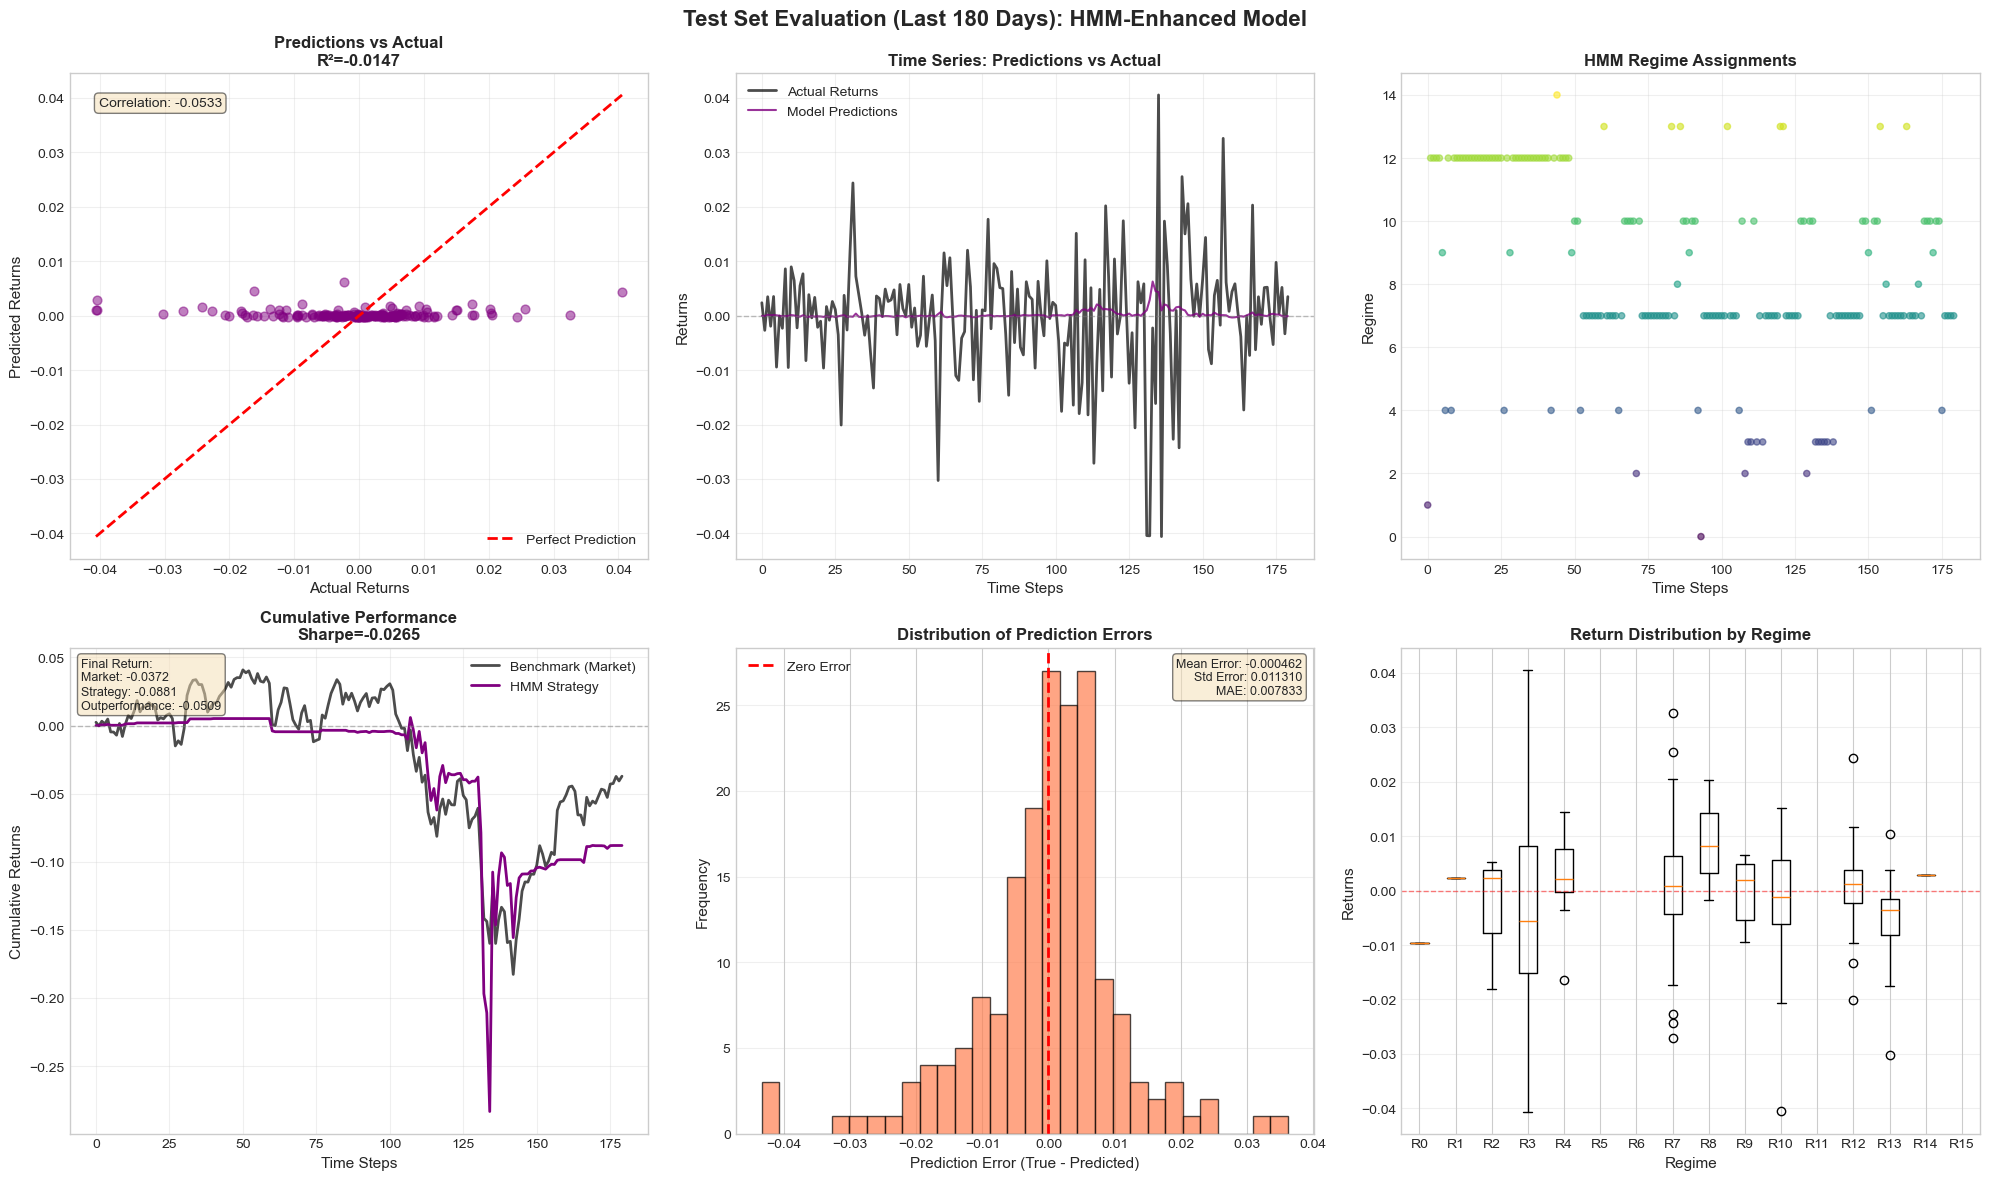


DETAILED TEST SET ANALYSIS

Prediction Statistics:
  Mean Prediction: 0.000255
  Std Prediction: 0.000816
  Min Prediction: -0.000335
  Max Prediction: 0.006268

Market Returns Statistics:
  Mean Return: -0.000207
  Std Return: 0.011237
  Min Return: -0.040582
  Max Return: 0.040544

Strategy Returns Statistics:
  Mean Strategy Return: -0.000489
  Std Strategy Return: 0.018487
  Total Cumulative Return (Market): -0.0372 (-3.72%)
  Total Cumulative Return (Strategy): -0.0881 (-8.81%)
  Outperformance: -0.0509

Directional Accuracy:
  Correct Direction Predictions: 88 / 180
  Hit Rate: 0.4889 (48.89%)

Model Quality Metrics:
  R² Score: -0.0147
  Correlation (Predictions vs Returns): -0.0533
  Mean Absolute Error: 0.007833
  Mean Squared Error: 0.000128
  Root Mean Squared Error: 0.011319

HMM Regime Statistics:
  Number of Regimes: 16
  Regime Distribution in Test Set:
    Regime 0: 1 samples (0.6%), Avg Return: -0.009632
    Regime 1: 1 samples (0.6%), Avg Return: 0.002371
    Regime 

In [11]:
# Visualize test set performance
print("\n--- Generating Test Set Visualizations ---\n")

plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle(f'Test Set Evaluation (Last {TEST_DAYS} Days): HMM-Enhanced Model', 
             fontsize=16, fontweight='bold')

# 1. Predictions vs Actual Returns
axes[0, 0].scatter(test_actual, test_predictions, alpha=0.5, s=40, color='purple')
axes[0, 0].plot([test_actual.min(), test_actual.max()], 
                [test_actual.min(), test_actual.max()], 
                'r--', linewidth=2, label='Perfect Prediction')
axes[0, 0].set_xlabel('Actual Returns', fontsize=11)
axes[0, 0].set_ylabel('Predicted Returns', fontsize=11)
axes[0, 0].set_title(f'Predictions vs Actual\nR²={test_r2:.4f}', 
                     fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

corr = np.corrcoef(test_actual, test_predictions)[0, 1]
axes[0, 0].text(0.05, 0.95, f'Correlation: {corr:.4f}', 
                transform=axes[0, 0].transAxes, fontsize=10, 
                verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 2. Time Series: Predictions and Actual Returns
test_time_index = range(len(test_actual))
axes[0, 1].plot(test_time_index, test_actual, 
                label='Actual Returns', color='black', linewidth=2, alpha=0.7)
axes[0, 1].plot(test_time_index, test_predictions, 
                label='Model Predictions', color='purple', linewidth=1.5, alpha=0.8)
axes[0, 1].set_xlabel('Time Steps', fontsize=11)
axes[0, 1].set_ylabel('Returns', fontsize=11)
axes[0, 1].set_title('Time Series: Predictions vs Actual', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].axhline(0, color='gray', linestyle='--', linewidth=1, alpha=0.5)

# 3. HMM Regime Assignments Over Time
regime_labels = X_test_with_regimes['regime'].values
axes[0, 2].scatter(test_time_index, regime_labels, c=regime_labels, 
                   cmap='viridis', alpha=0.6, s=20)
axes[0, 2].set_xlabel('Time Steps', fontsize=11)
axes[0, 2].set_ylabel('Regime', fontsize=11)
axes[0, 2].set_title('HMM Regime Assignments', fontsize=12, fontweight='bold')
axes[0, 2].grid(True, alpha=0.3)

# 4. Cumulative Returns
positions_clipped = np.clip(positions_test, 0, 2) * 1000
strategy_returns_clipped = positions_clipped * test_actual

cumulative_market = np.cumsum(test_actual)
cumulative_strategy = np.cumsum(strategy_returns_clipped)

axes[1, 0].plot(test_time_index, cumulative_market,
                label='Benchmark (Market)', color='black', linewidth=2, alpha=0.7)
axes[1, 0].plot(test_time_index, cumulative_strategy,
                label='HMM Strategy', color='purple', linewidth=2)
axes[1, 0].set_xlabel('Time Steps', fontsize=11)
axes[1, 0].set_ylabel('Cumulative Returns', fontsize=11)
axes[1, 0].set_title(f'Cumulative Performance\nSharpe={test_sharpe:.4f}', 
                     fontsize=12, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].axhline(0, color='gray', linestyle='--', linewidth=1, alpha=0.5)

perf_text = f'Final Return:\nMarket: {cumulative_market[-1]:.4f}\nStrategy: {cumulative_strategy[-1]:.4f}\nOutperformance: {(cumulative_strategy[-1] - cumulative_market[-1]):.4f}'
axes[1, 0].text(0.02, 0.98, perf_text, 
                transform=axes[1, 0].transAxes, fontsize=9, 
                verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 5. Prediction Error Distribution
prediction_errors = test_actual - test_predictions
axes[1, 1].hist(prediction_errors, bins=30, color='coral', alpha=0.7, edgecolor='black')
axes[1, 1].axvline(0, color='red', linestyle='--', linewidth=2, label='Zero Error')
axes[1, 1].set_xlabel('Prediction Error (True - Predicted)', fontsize=11)
axes[1, 1].set_ylabel('Frequency', fontsize=11)
axes[1, 1].set_title('Distribution of Prediction Errors', fontsize=12, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

mean_error = prediction_errors.mean()
std_error = prediction_errors.std()
error_text = f'Mean Error: {mean_error:.6f}\nStd Error: {std_error:.6f}\nMAE: {np.abs(prediction_errors).mean():.6f}'
axes[1, 1].text(0.98, 0.98, error_text, 
                transform=axes[1, 1].transAxes, fontsize=9, 
                verticalalignment='top', horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 6. Returns by Regime
axes[1, 2].boxplot([test_actual[regime_labels == i] 
                     for i in range(hmm_cluster.optimal_regimes)],
                    labels=[f'R{i}' for i in range(hmm_cluster.optimal_regimes)])
axes[1, 2].set_xlabel('Regime', fontsize=11)
axes[1, 2].set_ylabel('Returns', fontsize=11)
axes[1, 2].set_title('Return Distribution by Regime', fontsize=12, fontweight='bold')
axes[1, 2].grid(True, alpha=0.3, axis='y')
axes[1, 2].axhline(0, color='red', linestyle='--', linewidth=1, alpha=0.5)

plt.tight_layout()
plt.show()

# Print detailed statistics
print("\n" + "="*60)
print("DETAILED TEST SET ANALYSIS")
print("="*60)

print(f"\nPrediction Statistics:")
print(f"  Mean Prediction: {test_predictions.mean():.6f}")
print(f"  Std Prediction: {test_predictions.std():.6f}")
print(f"  Min Prediction: {test_predictions.min():.6f}")
print(f"  Max Prediction: {test_predictions.max():.6f}")

print(f"\nMarket Returns Statistics:")
print(f"  Mean Return: {test_actual.mean():.6f}")
print(f"  Std Return: {test_actual.std():.6f}")
print(f"  Min Return: {test_actual.min():.6f}")
print(f"  Max Return: {test_actual.max():.6f}")

print(f"\nStrategy Returns Statistics:")
print(f"  Mean Strategy Return: {strategy_returns_clipped.mean():.6f}")
print(f"  Std Strategy Return: {strategy_returns_clipped.std():.6f}")
print(f"  Total Cumulative Return (Market): {cumulative_market[-1]:.4f} ({cumulative_market[-1]*100:.2f}%)")
print(f"  Total Cumulative Return (Strategy): {cumulative_strategy[-1]:.4f} ({cumulative_strategy[-1]*100:.2f}%)")
print(f"  Outperformance: {(cumulative_strategy[-1] - cumulative_market[-1]):.4f}")

print(f"\nDirectional Accuracy:")
print(f"  Correct Direction Predictions: {int(test_hit_rate * len(test_actual))} / {len(test_actual)}")
print(f"  Hit Rate: {test_hit_rate:.4f} ({test_hit_rate*100:.2f}%)")

print(f"\nModel Quality Metrics:")
print(f"  R² Score: {test_r2:.4f}")
print(f"  Correlation (Predictions vs Returns): {corr:.4f}")
print(f"  Mean Absolute Error: {np.abs(prediction_errors).mean():.6f}")
print(f"  Mean Squared Error: {(prediction_errors**2).mean():.6f}")
print(f"  Root Mean Squared Error: {np.sqrt((prediction_errors**2).mean()):.6f}")

print(f"\nHMM Regime Statistics:")
print(f"  Number of Regimes: {hmm_cluster.optimal_regimes}")
print(f"  Regime Distribution in Test Set:")
for i in range(hmm_cluster.optimal_regimes):
    count = np.sum(regime_labels == i)
    pct = count / len(regime_labels) * 100
    avg_return = test_actual[regime_labels == i].mean() if count > 0 else 0
    print(f"    Regime {i}: {count} samples ({pct:.1f}%), Avg Return: {avg_return:.6f}")

print("="*60)